In [ ]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import multiprocessing.pool
from tqdm import tqdm

In [ ]:
def generate_matrix(a=-10, b=10, n=3):
    return np.random.uniform(a, b, size=(n, n))

def cut_matrix(A):
    mid = len(A) // 2
    return A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]

def mul_matrix(matrix1, matrix2):
    assert len(matrix1[0]) == len(matrix2)
    return np.array([
        [sum(matrix1[i][k] * matrix2[k][j] for k in range(len(matrix2[0])))
         for j in range(len(matrix2[0]))]
        for i in range(len(matrix1))
    ])

def strassen(A, B, border=32):
    if len(A) <= border:
        return mul_matrix(A, B)
    A11, A12, A21, A22 = cut_matrix(A)
    B11, B12, B21, B22 = cut_matrix(B)

    P1 = strassen(A11 + A22, B11 + B22, border)
    P2 = strassen(A21 + A22, B11, border)
    P3 = strassen(A11, B12-B22, border)
    P4 = strassen(A22, B21 - B11, border)
    P5 = strassen(A11 + A12, B22, border)
    P6 = strassen(A21 - A11, B11 + B12, border)
    P7 = strassen(A12 - A22, B21 + B22, border)


    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 + P3 - P2 + P6

    return np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))

def strassen_multiprocessing(A, B, border=64):
    if len(A) <= border:
        return mul_matrix(A, B)
    A11, A12, A21, A22 = cut_matrix(A)
    B11, B12, B21, B22 = cut_matrix(B)

    pool = multiprocessing.pool.ThreadPool(processes=7)

    P1 = pool.apply_async(strassen, (A11 + A22, B11 + B22, border)).get()
    P2 = pool.apply_async(strassen, (A21 + A22, B11, border)).get()
    P3 = pool.apply_async(strassen, (A11, B12-B22, border)).get()
    P4 = pool.apply_async(strassen, (A22, B21 - B11, border)).get()
    P5 = pool.apply_async(strassen, (A11 + A12, B22, border)).get()
    P6 = pool.apply_async(strassen, (A21 - A11, B11 + B12, border)).get()
    P7 = pool.apply_async(strassen, (A12 - A22, B21 + B22, border)).get()

    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 + P3 - P2 + P6

    return np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))


In [ ]:
A = generate_matrix(n=128)
B = generate_matrix(n=128)

result = A @ B
result_st = strassen(A, B)
result_st_multi = strassen_multiprocessing(A, B)

print(f"strassen error: {np.linalg.norm(abs(result - result_st))}")
print(f"strassen_multi_error: {np.linalg.norm(abs(result - result_st_multi))}")

strassen error: 4.4850370123209495e-11
strassen_multi_error: 4.4850370123209495e-11


100%|██████████| 7/7 [00:42<00:00,  6.11s/it]


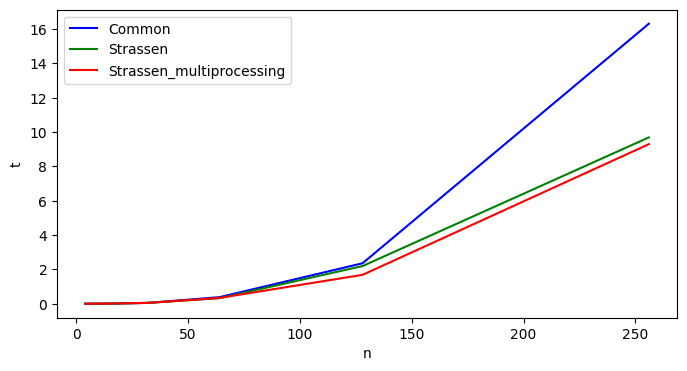

In [ ]:
dims = [2 ** i for i in range(2, 9)]
times_common = []
times_st = []
times_st_multi = []

for dim in tqdm(dims):
    A = generate_matrix(n=dim)
    B = generate_matrix(n=dim)

    start = time()
    _ = strassen(A, B)
    times_st.append(time() - start)

    start = time()
    _ = strassen_multiprocessing(A, B)
    times_st_multi.append(time() - start)

    start = time()
    _ = mul_matrix(A ,B)
    times_common.append(time() - start)


plt.figure(figsize=(8, 4))
plt.xlabel("n")
plt.ylabel("t")
plt.plot(dims, times_common, label="Common", color = "blue")
plt.plot(dims, times_st, label="Strassen", color = "green")
plt.plot(dims, times_st_multi, label="Strassen_multiprocessing", color = "red")
plt.legend()
plt.show()